In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as ds
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        class_names = self.imageFolderDataset.classes
        class_indices = self.imageFolderDataset.class_to_idx
        random_class = random.choice(class_names)
        # decide get the same class img
        get_same_class = random.randint(0,1) 
        
        sample_indices = []
        for index, label in enumerate(self.imageFolderDataset.targets):
            if get_same_class and label == class_indices[random_class]:
                sample_indices.append(index)
            elif not get_same_class and label != class_indices[random_class]:
                sample_indices.append(index)
        
        random_indices = random.sample(sample_indices, 2)
        
        img_1, label_1 = self.imageFolderDataset[random_indices[0]]
        img_2, label_2 = self.imageFolderDataset[random_indices[1]]

        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
        # 1 means the pairs are diff, 0 means same
        return img_1, img_2 , torch.from_numpy(np.array([int(label_1!=label_2)],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [4]:
# data_root = "/home/walter/git/Siamese_object_recognition/data"
# folder_dataset = ds.ImageFolder(root=data_root)
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
#                                         transform=transforms.Compose([transforms.Resize((100,100)),
#                                                                       transforms.ToTensor()]))

# vis_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=8,
#                         batch_size=8)

# dataiter = iter(vis_dataloader)
# dataiter
# example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

## Model

In [5]:
from torchvision.models import list_models, efficientnet_b0, EfficientNet_B0_Weights, inception_v3, Inception_V3_Weights

In [6]:
# list_models()

In [7]:
from torchvision import models

class SiameseNetwork(nn.Module):
    def __init__(self, backbone="resnet50"):
        super(SiameseNetwork, self).__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights)
        
        self.cls_head = nn.Sequential(
            nn.Linear(1000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 64)
        )

    def forward_once(self, x):
        output = self.backbone(x)
        output = output.view(output.size()[0], -1)
        output = self.cls_head(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Loss

In [8]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training 

In [9]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

Number of CPU cores: 36


In [10]:
train_dataset_root = os.getcwd() + "/data/training/"
imgs_folder_dataset = ds.ImageFolder(root=train_dataset_root)

transform=transforms.Compose([
    transforms.Resize((224,224),antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ])

train_dataset = SiameseNetworkDataset(imgs_folder_dataset, transform=transform)

train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=num_cores-1,
                        batch_size=32)

In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.01 )

/home/walter/miniconda3/envs/siamese/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
epoches = []
loss_history = [] 
train_epoch = 20

Epoch number 1
 Current loss 14.903326034545898

Epoch number 2
 Current loss 7.943696022033691

Epoch number 3
 Current loss 3.751967430114746

Epoch number 4
 Current loss 2.0910377502441406

Epoch number 5
 Current loss 1.4044448137283325

Epoch number 6
 Current loss 0.8548480272293091

Epoch number 7
 Current loss 0.6749609112739563

Epoch number 8
 Current loss 1.0204216241836548

Epoch number 9
 Current loss 1.5611742734909058

Epoch number 10
 Current loss 1.1675530672073364

Epoch number 11
 Current loss 0.9281588792800903

Epoch number 12
 Current loss 1.1830945014953613

Epoch number 13
 Current loss 0.8686003684997559

Epoch number 14
 Current loss 0.8092570304870605

Epoch number 15
 Current loss 1.1106925010681152

Epoch number 16
 Current loss 1.0216819047927856

Epoch number 17
 Current loss 0.8719683885574341

Epoch number 18
 Current loss 0.9107894897460938

Epoch number 19
 Current loss 1.0468332767486572

Epoch number 20
 Current loss 0.9140763282775879



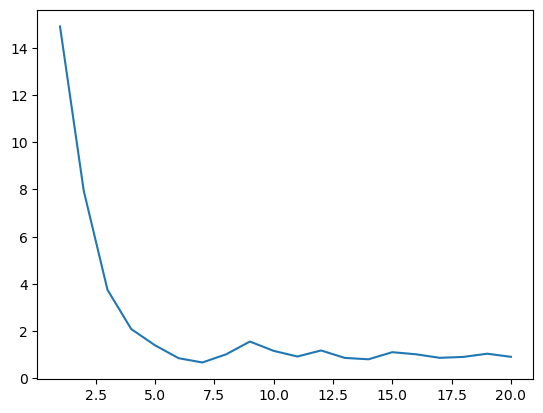

In [13]:
for epoch in range(1, train_epoch+1):
    for batch in train_dataloader:
        img0, img1, label = batch
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
    print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
    epoches.append(epoch)
    loss_history.append(loss_contrastive.item())

show_plot(epoches,loss_history)

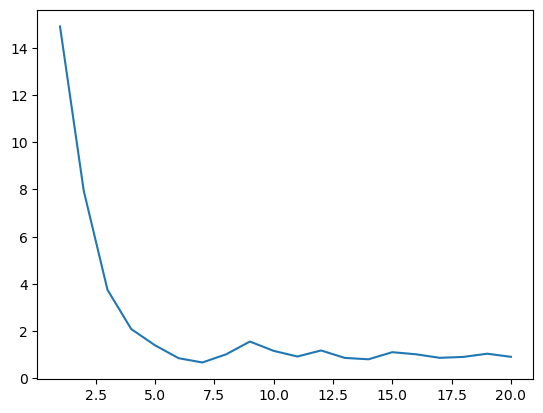

In [14]:
torch.save(net.state_dict(), 'model_weights.pth')
show_plot(epoches,loss_history)

## EVAL

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
testset_root = os.getcwd() + "/data/testing/"
imgs_folder_dataset = ds.ImageFolder(root=testset_root)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224),antialias=True),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ])

test_dataset = SiameseNetworkDataset(imgs_folder_dataset, transform=transform)
test_dataloader = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=num_cores-1,
                        batch_size=1)

In [17]:
checkpoint = torch.load('model_weights.pth')
model = SiameseNetwork()
model.to(device)
model.load_state_dict(checkpoint)
model.eval()

SiameseNetwork(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sca

In [18]:
criterion = ContrastiveLoss()
correct = 0
total = 0

In [19]:
label_diff = torch.tensor([0.]).to(device)
print(label_diff)
for img0, img1, labels in test_dataloader:
    label = labels[0]
    img0, img1, label = map(lambda x: x.to(device), [img0, img1, label])
    output1, output2 = model(img0, img1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    correct += torch.count_nonzero(label == (euclidean_distance.item() > 0.5)).item()
    total += 1

print(correct / total * 100)

tensor([0.], device='cuda:0')
66.61676646706587
